In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
file_count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    file_count += len(filenames)

print(f"Всього файлів у /kaggle/input: {file_count}")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Всього файлів у /kaggle/input: 2692


In [2]:
!pip install ultralytics > /dev/null

In [3]:
import os
import shutil
import torch
import torchvision
import matplotlib.pyplot as plt
import yaml
import cv2
import glob
import pandas as pd
import sys

from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from ultralytics import YOLO
from contextlib import contextmanager

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
DATA_DIR = "/kaggle/input/indoor-object-detection"  # шлях до датасету на Kaggle

In [5]:
# Перевірка файлів у директоріях
print("Папки у датасеті:", os.listdir(DATA_DIR))
print("Папка train/images:", os.listdir(os.path.join(DATA_DIR, "train", "images"))[:5])

# Читаємо data.yaml, який повинен бути у датасеті або створимо локально
yaml_path = "./data.yaml"

Папки у датасеті: ['data.yaml', 'valid', 'test', 'train']
Папка train/images: ['263523d1754e3381.jpg', '1ae7acb4547d5bc0.jpg', '0e8139635a72ecb8.jpg', 'a0da5e7cc4ba2d79.jpg', '0410943ef1919f80.jpg']


In [6]:
if os.path.exists(yaml_path):
    print(f"Файл '{yaml_path}' вже існує. Перезаписувати не будемо.")
else:
    data_yaml = f"""
train: {DATA_DIR}/train/images
val: {DATA_DIR}/valid/images
test: {DATA_DIR}/test/images
nc: 10
names:
  - door
  - cabinetDoor
  - refrigeratorDoor
  - window
  - chair
  - table
  - cabinet
  - couch
  - openedDoor
  - pole
"""
    with open(yaml_path, "w") as f:
        f.write(data_yaml)
    print("Файл data.yaml створено")

Файл data.yaml створено


In [7]:
# Завантажуємо назви класів
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
class_names = data['names']

# Функція для відображення bounding box із YOLO анотацій
def draw_yolo_bbox(image_path, label_path, class_names):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        cls, cx, cy, bw, bh = map(float, line.strip().split())
        cls = int(cls)

        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)

        cv2.rectangle(image,(x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, class_names[cls], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [8]:
test_dir = "/kaggle/input/indoor-object-detection/test"
print("Вміст папки test:", os.listdir(test_dir))

Вміст папки test: ['labels', 'images']


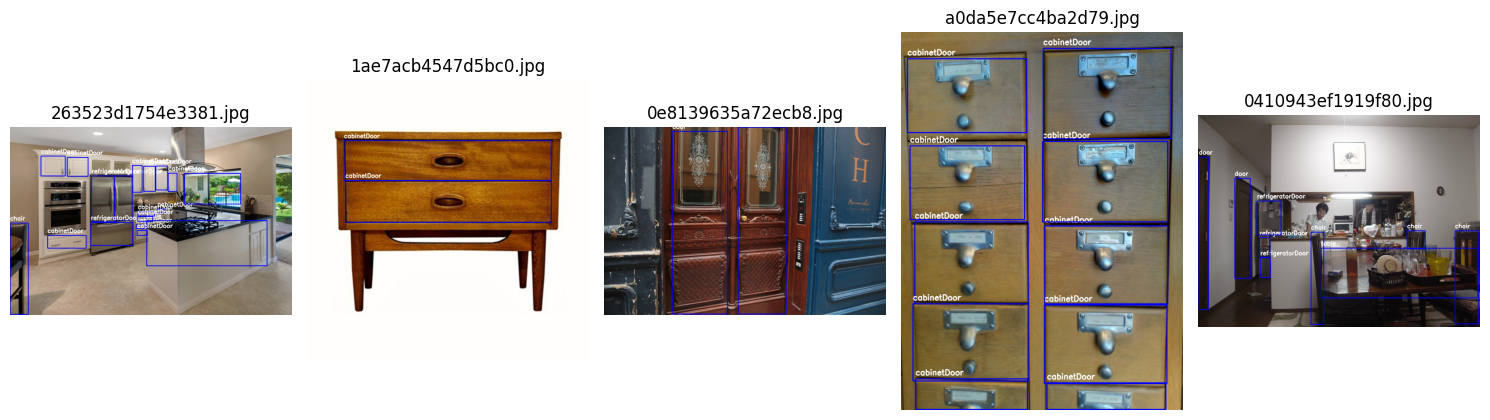

In [9]:
# Приклад візуалізації 5 зображень з тренувальної вибірки
image_dir = os.path.join(DATA_DIR, "train", "images")
label_dir = os.path.join(DATA_DIR, "train", "labels")
image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))[:5]

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(image_paths):
    label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
    img = draw_yolo_bbox(img_path, label_path, class_names)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [28]:
# Ініціалізація моделі YOLOv8l
model = YOLO("yolov8m.pt")  # Замість yolov8s.pt ставимо yolov8l.pt

# Параметри аугментації (якщо хочеш — залишаємо без змін)
augmentations = {
    'blur': 0.05,
    'median_blur': 0.05,
    'clahe': 0.05,
    'rotate': 0.2,
    'brightness': 0.15,
    'contrast': 0.15,
    'flipud': 0.5,
    'fliplr': 0.5,
}

# Навчання
model.train(
    data=yaml_path,
    epochs=40,
    imgsz=640,
    batch=32, 
    lr0=0.0015,           
    project="/kaggle/working/indoor_yolo_training",
    name="yolov8m_indoor",
    exist_ok=True,
    augment=True,
    save=True,
    save_period=1,
    resume=False,
    verbose=False
)

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_indoor, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:01<00:00, 767.17it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 214.1±64.1 MB/s, size: 217.7 KB)


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 953.54it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.


Plotting labels to /kaggle/working/indoor_yolo_training/yolov8m_indoor/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/indoor_yolo_training/yolov8m_indoor
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      12.3G      1.688      2.992      1.565        180        640: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        230       1289        0.4      0.196      0.165     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      11.6G      1.451      1.732      1.349        173        640: 100%|██████████| 32/32 [00:32<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        230       1289      0.558      0.232      0.186     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      11.7G      1.456      1.737       1.37        154        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        230       1289      0.454       0.26      0.141     0.0749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      11.8G      1.476      1.756      1.397        160        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        230       1289      0.555      0.147       0.12     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      11.9G       1.46       1.66      1.383        189        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        230       1289      0.492      0.189      0.138     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      11.7G      1.448       1.61      1.371        144        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        230       1289      0.338      0.297      0.201      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      11.8G      1.412      1.484      1.356        150        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        230       1289      0.447      0.299      0.245      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      11.9G      1.399      1.487      1.368        228        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        230       1289       0.51      0.243      0.242      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      11.8G      1.378      1.388      1.316        197        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        230       1289      0.426      0.283      0.245      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      11.7G      1.351      1.407      1.326        163        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        230       1289      0.514      0.297      0.274      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      11.7G      1.353      1.336      1.317        258        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        230       1289      0.534      0.275      0.288       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      11.8G      1.303      1.274      1.292        178        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289      0.632      0.281      0.305      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      11.9G      1.296       1.23      1.297        212        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.406      0.353      0.292      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      11.8G      1.299      1.196       1.28        199        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289       0.71      0.358      0.443      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      11.9G      1.274      1.195      1.276        279        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        230       1289      0.415      0.321      0.321      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      11.6G      1.263      1.117      1.259        224        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289      0.479      0.346      0.354      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      11.8G      1.225      1.066      1.235        161        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        230       1289      0.321      0.405      0.361      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      11.9G       1.21      1.022      1.226        256        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.382      0.366      0.355      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      11.6G        1.2      1.024      1.227        236        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289      0.385      0.439      0.356      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      11.8G      1.177      1.002      1.214        313        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289      0.296      0.388      0.344      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      11.7G      1.177     0.9598      1.208        202        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289      0.399      0.361      0.336        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      11.8G       1.17     0.9328      1.202        185        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.408      0.382      0.359      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      11.9G      1.146     0.9133      1.199        160        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        230       1289      0.391      0.382      0.372      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      11.7G      1.121     0.8907      1.174        180        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.423      0.476      0.422      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      11.9G      1.089     0.8493      1.163        189        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.358      0.502      0.445      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      11.8G      1.095     0.8398      1.154        154        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.477      0.442      0.406      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      11.8G      1.071     0.8106       1.16        200        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.399      0.517      0.469      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      11.4G      1.063     0.7887      1.141        282        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.651      0.436      0.479      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      11.6G      1.052      0.757      1.136        135        640: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289      0.426      0.447      0.396      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      11.9G      1.025     0.7513      1.136        135        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.401      0.434      0.409      0.228


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.9G      1.039     0.7166      1.128        138        640: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        230       1289        0.4       0.53      0.427      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      11.9G     0.9912     0.6333      1.115        106        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.484      0.397      0.383      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      11.8G     0.9685      0.601      1.098        143        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.354      0.399      0.381      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      11.9G     0.9539     0.5857      1.088        104        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289      0.421      0.524      0.425      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      11.9G     0.9414     0.5625      1.082        108        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.644      0.391      0.476      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      11.8G     0.9119     0.5434      1.067        157        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        230       1289        0.4      0.483      0.409      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      11.8G     0.9021     0.5289       1.06        152        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.577      0.474      0.436      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      11.9G       0.87     0.4938      1.047        124        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289      0.524      0.388      0.402      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      11.8G     0.8608     0.4893      1.032         79        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        230       1289       0.53      0.395      0.399      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      11.8G     0.8463     0.4841      1.035         73        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        230       1289      0.415      0.406      0.402      0.248



40 epochs completed in 0.411 hours.
Optimizer stripped from /kaggle/working/indoor_yolo_training/yolov8m_indoor/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/working/indoor_yolo_training/yolov8m_indoor/weights/best.pt, 52.0MB

Validating /kaggle/working/indoor_yolo_training/yolov8m_indoor/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        230       1289      0.766      0.405      0.495      0.333
Speed: 0.2ms preprocess, 22.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/indoor_yolo_training/yolov8m_indoor


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78e6109319d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [29]:
# Інференс на тестових зображеннях
test_images_dir = "/kaggle/input/indoor-object-detection/test/images"
results = model.predict(
    source=test_images_dir, 
    save=True, 
    conf=0.25, 
    save_dir="/kaggle/working/indoor_yolo_training/inference_results"
)

print("Результати інференсу збережені у папку:", "/kaggle/working/indoor_yolo_training/inference_results")

Results saved to /kaggle/working/indoor_yolo_training/yolov8m_indoor
Результати інференсу збережені у папку: /kaggle/working/indoor_yolo_training/inference_results


In [30]:
metrics = model.val()
class_names = list(metrics.names.values())

# precision, recall, ap50, ap95 по класах в metrics.box:
# p, r, ap50, ap95 — це списки по класах

data = {
    "Class": list(metrics.names.values()),
    "Precision": metrics.box.p.tolist(),  # precision по класах
    "Recall": metrics.box.r.tolist(),      # recall по класах
    "mAP@0.5": metrics.box.ap50.tolist(),  # mAP@0.5 по класах
    "mAP@0.5:0.95": metrics.box.ap.tolist()  # mAP@0.5:0.95 по класах
}

df = pd.DataFrame(data)
df.index.name = "Index"
print(df.round(3))

# Збереження метрик у CSV
df.to_csv("/kaggle/working/indoor_metrics.csv", index=False)

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 659.1±507.7 MB/s, size: 411.9 KB)


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 732.12it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        230       1289      0.659      0.404      0.492      0.332
Speed: 2.0ms preprocess, 40.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/indoor_yolo_training/yolov8m_indoor
                  Class  Precision  Recall  mAP@0.5  mAP@0.5:0.95
Index                                                            
0                  door      0.720   0.474    0.578         0.377
1           cabinetDoor      0.891   0.685    0.828         0.481
2      refrigeratorDoor      0.883   0.709    0.837         0.558
3                window      0.428   0.214    0.304         0.180
4                 chair      0.769   0.475    0.633         0.354
5                 table      0.490   0.200    0.238         0.126
6               cabinet      0.762   0.281    0.399         0.288
7                 couch      0.648   1.000    0.995         0.896
8            openedDoor      0.000   0.000    0.079         0.048
9                  pole      1.00

In [31]:
print(f"📊 mAP@0.5: {metrics.box.map50:.4f}")
print(f"📊 mAP@0.5:0.95: {metrics.box.map:.4f}")

mean_precision = sum(metrics.box.p) / len(metrics.box.p)
mean_recall = sum(metrics.box.r) / len(metrics.box.r)
mean_f1 = sum(metrics.box.f1) / len(metrics.box.f1)

print(f"📈 Precision (mean по класах): {mean_precision:.4f}")
print(f"📉 Recall (mean по класах): {mean_recall:.4f}")
print(f"✅ F1-score (mean по класах): {mean_f1:.4f}")

📊 mAP@0.5: 0.4919
📊 mAP@0.5:0.95: 0.3319
📈 Precision (mean по класах): 0.6592
📉 Recall (mean по класах): 0.4038
✅ F1-score (mean по класах): 0.4486


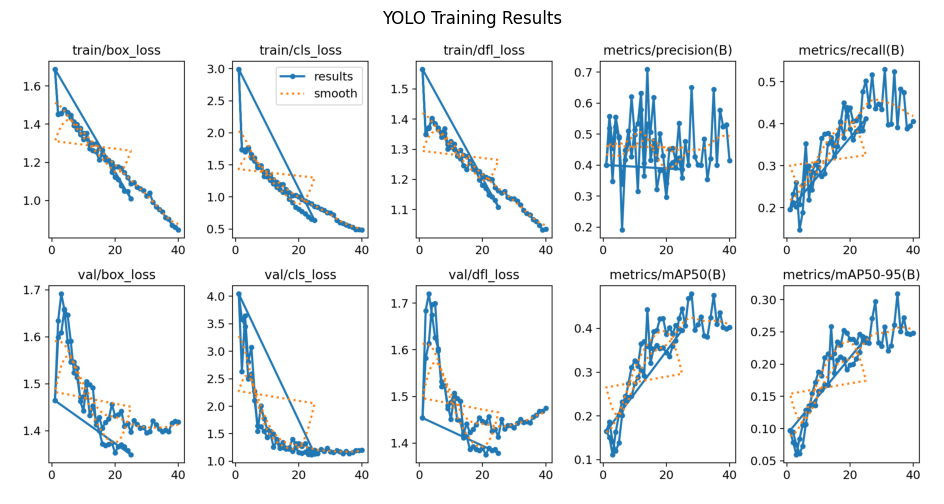

In [32]:
results_path = "/kaggle/working/indoor_yolo_training/yolov8m_indoor/results.png"

# Відкриваємо та відображаємо, якщо файл існує
if os.path.exists(results_path):
    img = Image.open(results_path)
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("YOLO Training Results")
    plt.show()
else:
    print(f"❌ Файл не знайдено: {results_path}")

In [33]:
base_path = "/kaggle/working/indoor_yolo_training/yolov8m_indoor"
print("Файли у директорії:")
print(os.listdir(base_path))

Файли у директорії:
['1123.jpg', '1101.jpg', '1239.jpg', '1382.jpg', '1040.jpg', '923.jpg', '1095.jpg', '1058.jpg', '1187.jpg', '1137.jpg', '1113.jpg', '921.jpg', '1253.jpg', '1281.jpg', 'val_batch0_pred.jpg', 'confusion_matrix_normalized.png', '1048.jpg', '1357.jpg', '1119.jpg', '110.jpg', '1344.jpg', '1302.jpg', '1054.jpg', '1069.jpg', '1071.jpg', 'train_batch482.jpg', 'BoxR_curve.png', '1104.jpg', '1245.jpg', '1209.jpg', '908.jpg', '888.jpg', '127.jpg', '1015.jpg', '1339.jpg', '1122.jpg', '1021.jpg', '1027.jpg', '1154.jpg', '118.jpg', '1217.jpg', '1290.jpg', '126.jpg', '1278.jpg', 'train_batch2.jpg', '1026.jpg', '1089.jpg', '1338.jpg', '1032.jpg', '1079.jpg', '1342.jpg', '999.jpg', '1269.jpg', '1186.jpg', 'weights', 'val_batch1_pred.jpg', '1323.jpg', '1320.jpg', '1020.jpg', 'results.png', 'BoxF1_curve.png', '954.jpg', '1300.jpg', '925.jpg', 'val_batch1_labels.jpg', '1329.jpg', 'train_batch962.jpg', '1195.jpg', '1310.jpg', '1045.jpg', '1028.jpg', '1311.jpg', '1145.jpg', '12.jpg', '12

In [34]:
# Шлях до метрик у форматі txt або JSON
metrics_path = "/kaggle/working/indoor_yolo_training/yolov8m_indoor/results.csv"

# Альтернативно, якщо є `metrics.json`:
# import json
# with open('/kaggle/working/runs/detect/train/metrics.json', 'r') as f:
#     metrics = json.load(f)

# Читаємо CSV метрик, якщо він створився
df = pd.read_csv(metrics_path)
df  # Показуємо останні епохи — там найкращі результатиазуємо останні епохи — там найкращі результати

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,37.5617,1.68762,2.99224,1.56549,0.40008,0.19556,0.16476,0.09688,1.46416,4.04389,1.45393,0.000221,0.000221,0.000221
1,2,75.6014,1.45285,1.74003,1.34871,0.51937,0.21230,0.15103,0.07842,1.63423,3.58493,1.68390,0.000432,0.000432,0.000432
2,3,112.3890,1.45432,1.70431,1.37235,0.34780,0.20182,0.11140,0.05967,1.69161,3.45169,1.71977,0.000625,0.000625,0.000625
3,4,149.5010,1.47427,1.77120,1.40248,0.52401,0.20717,0.16275,0.08415,1.65738,2.49982,1.67470,0.000629,0.000629,0.000629
4,5,186.3270,1.45396,1.60568,1.38464,0.48789,0.25306,0.20288,0.10526,1.59034,2.58569,1.62598,0.000601,0.000601,0.000601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,36,1332.9200,0.91187,0.54339,1.06689,0.40004,0.48252,0.40949,0.25055,1.40125,1.14031,1.45605,0.000095,0.000095,0.000095
61,37,1369.4600,0.90209,0.52890,1.06006,0.57745,0.47426,0.43644,0.27183,1.39779,1.16259,1.45994,0.000078,0.000078,0.000078
62,38,1405.9000,0.87001,0.49380,1.04746,0.52373,0.38796,0.40233,0.24778,1.41640,1.19849,1.46833,0.000060,0.000060,0.000060
63,39,1442.3800,0.86077,0.48934,1.03235,0.52978,0.39466,0.39933,0.24649,1.42046,1.19693,1.46785,0.000042,0.000042,0.000042


In [35]:
# Завантажуємо натреновану модель
model = YOLO('/kaggle/working/indoor_yolo_training/yolov8m_indoor/weights/best.pt')

# Проводимо валідацію ще раз (мовчки, без виводу)
metrics = model.val()

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 303.2±298.4 MB/s, size: 213.2 KB)


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 1122.45it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        230       1289      0.634      0.389      0.476      0.309
                  door         63         97      0.634      0.464       0.54      0.343
           cabinetDoor         99        765      0.863      0.745      0.829      0.484
      refrigeratorDoor         85        192      0.858      0.651      0.806      0.536
                window         39         91      0.439      0.242      0.269       0.16
                 chair         24         49      0.775      0.388      0.596      0.311
                 table         30         40      0.343      0.125      0.238      0.121
               cabinet         28         32       0.56      0.279      0.399      0.293
                 couch          1          1      0.868          1      0.995      0.796
            openedDoor         13         13          0          0     0.0717     0.0403
                  pole          4          9          1          0     0.0168    0.00802
Speed: 0.7ms preproce


0: 480x640 6 cabinetDoors, 23.8ms
1: 480x640 1 window, 2 chairs, 23.8ms
2: 480x640 2 doors, 1 window, 1 chair, 1 couch, 23.8ms
3: 480x640 1 window, 23.8ms
4: 480x640 1 chair, 1 table, 23.8ms
Speed: 2.5ms preprocess, 23.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /kaggle/working/indoor_yolo_training/yolov8m_indoor_results2


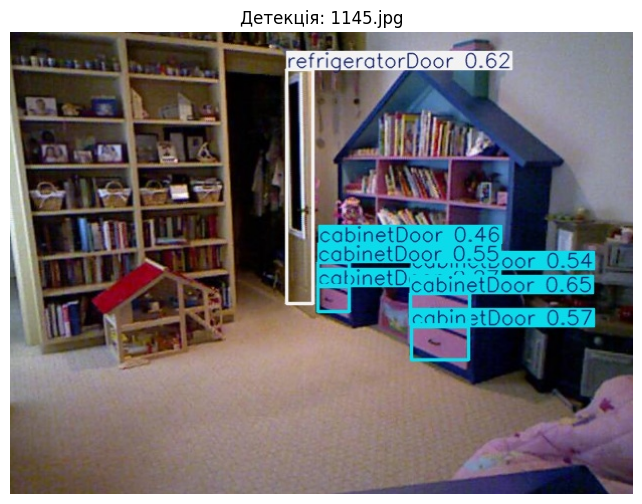

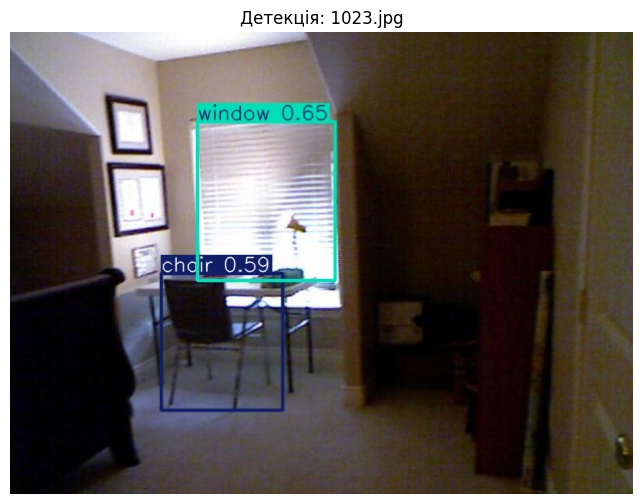

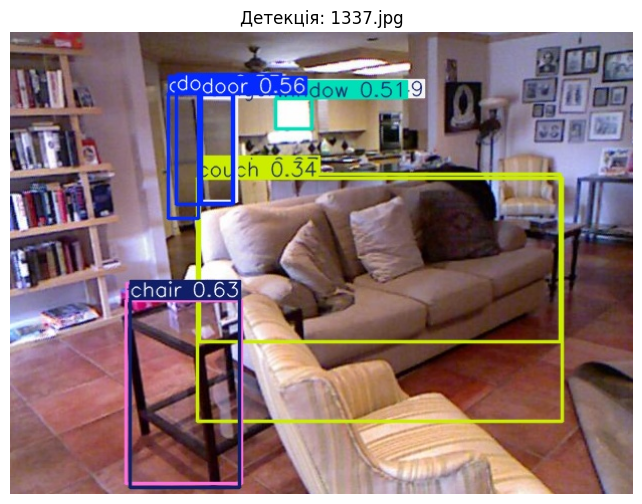

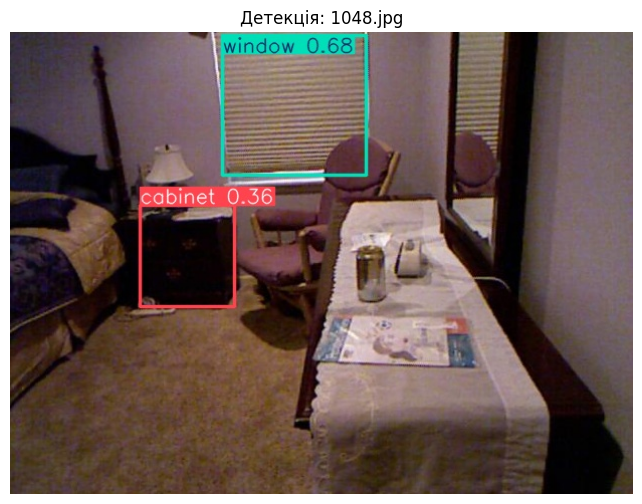

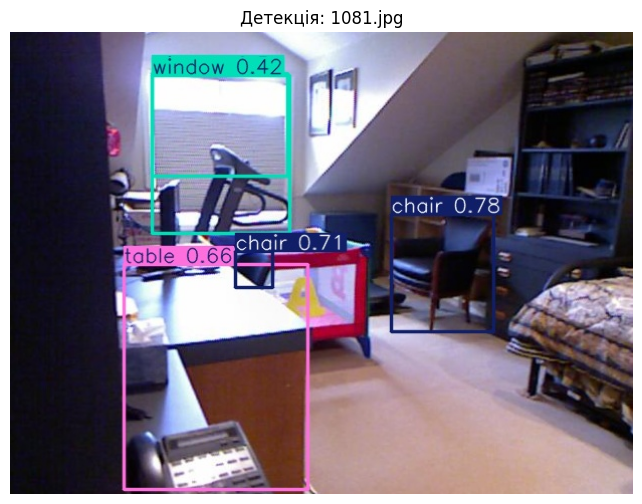

In [36]:
# Вибираємо 5 конкретних зображень із тестової папки для інференсу
image_paths = glob.glob('/kaggle/input/indoor-object-detection/test/images/*.png')[:5]

# Папка проєкту та ім’я експерименту
project_dir = "/kaggle/working/indoor_yolo_training"
exp_name = "yolov8m_indoor_results"

# Робимо інференс: збереження результатів + встановлення порогу впевненості
results = model.predict(
    source=image_paths,
    conf=0.25,
    save=True,
    project=project_dir,
    name=exp_name
)

# Тепер результати зберігаються у /kaggle/working/indoor_yolo_training/yolov8l_indoor_results/
save_dir = os.path.join(project_dir, exp_name)

# Візуалізація збережених результатів
for path in image_paths:
    filename = os.path.splitext(os.path.basename(path))[0] + ".jpg"  # зміна тут
    result_img_path = os.path.join(save_dir, filename)

    if os.path.exists(result_img_path):
        img = cv2.imread(result_img_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Детекція: {filename}")
        plt.axis('off')
        plt.show()
    else:
        print(f"[!] Не знайдено збережене зображення: {result_img_path}")


**РЕЗУЛЬТАТИ** (на валідаційному наборі)

**ЗАГАЛЬНІ РЕЗУЛЬТАТИ ПО КЛАСАХ**
<br>mAP@0.5:                    0.4919
<br>mAP@0.5:0.95:               0.3319
<br>Precision (mean по класах): 0.6592
<br>Recall (mean по класах):    0.4038
<br>F1-score (mean по класах):  0.4486

**МЕТРИКИ ПО КЛАСАХ:**

Клас	                Precision	Recall	mAP@0.5	mAP@0.5:0.95
<br> door	            0.720	0.474	0.578	0.377
<br>cabinetDoor	        0.891	0.685	0.828	0.481
<br>refrigeratorDoor	0.883	0.709	0.837	0.558
<br>window	0.428	0.214	0.304	0.180
<br>chair	0.769	0.475	0.633	0.354
<br>table	0.490	0.200	0.238	0.126
<br>cabinet	0.762	0.281	0.399	0.288
<br>couch	0.648	1.000	0.995	0.896
<br>openedDoor	0.000	0.000	0.079	0.048
<br>pole	1.000	0.000	0.027	0.011

**Найкращі класи:**
<br>couch, refrigeratorDoor, cabinetDoor — висока точність, повнота і mAP@0.5:0.95

**Слабкі класи:**
<br>openedDoor та pole — майже повна відсутність коректного передбачення
<br>window, table — погана recall і низька точність

**ПРОБЛЕМИ, ВИЯВЛЕНІ ПІД ЧАС АНАЛІЗУ:**

<br>Дисбаланс класів:
<br>openedDoor, pole мають дуже мало прикладів у тренувальному наборі → модель їх не вивчає.

<br>Візуальна схожість класів:
<br>door, openedDoor, cabinetDoor — модель плутає через схожі риси (форма, текстура, кольори).

<br>Recall по багатьох класах низький:
<br>Модель часто не знаходить об’єкти, навіть якщо знає, як вони виглядають (недостатня генералізація).
<br>Проблеми з дрібними або частково прихованими об'єктами.

**ЩО МОЖНА ПОКРАЩИТИ:**

Модель / Навчання:
<br>1 Перейти до YOLOv8l або YOLOv9 - були спроби навчання різних моделей, але на короткій відстані (25-30 епох) це не надало відчутних результатів.
<br>Збільшити imgsz=768 але при умові збільшення до розміру imgsz=960 — потрібно використовувати потужний ПК так як середній не витягую - це можливо дасть моделі більше контексту.
<br>Збільшити epochs=80–100 з early stopping.
<br>Налаштувати class weights або зробити oversampling для openedDoor, pole.


Дані:
<br>Додати зображення або згенерувати аугментовані приклади для рідкісних класів (openedDoor, pole).
<br>Створити власну класову ієрархію, наприклад об'єднати door + openedDoor, якщо задача допускає.

<br>Метрики:
<br>Додати F1-score per class — дозволить краще розуміти баланс precision/recall.
<br>Провести confusion matrix по класах — візуально визначити, що модель плутає.

**ЗАГАЛЬНИЙ ВИСНОВОК**

Було побудувано робочий прототип системи об'єктного розпізнавання у приміщенні на основі YOLOv8m, який:
<br>Виявляє основні класи з хорошою точністю.
<br>Має потенціал до покращення за рахунок збільшення епох, розміру зображень та роботи з даними.
<br>Готовий для інтеграції або як основа для подальших досліджень/навчання.